In [1]:
# Title:

In [3]:
# packages
import datetime as dt
import pandas as pd

import utils

2024-03-05 19:44:53.177 | INFO     | quantified_strategies.ml_utils:get_device:26 - Running on the CPU


In [4]:
from loguru import logger
import typing as t

from quantified_strategies.event_trading import russell_rebalance, super_bowl
from quantified_strategies.overnight_trading import short_term_reversal
from quantified_strategies.seasonal_trading import (
    buy_when_yields_are_low, pay_day_strategy, santa_claus_strategy, september_bear, tax_day_strategy, turn_around_tuesday_strategy)
from quantified_strategies.technical_trading import contrarian_trading

from quantified_strategies import strategy_utils

def get_active_strategies(strategy_map: t.Dict[str, str | t.List[str]], date: dt.date, verbose: bool = True) -> t.Dict[str, t.List[str]]:
    
    strategy_map_list = {strat: universe if isinstance(universe, list) else [universe] for strat, universe in strategy_map.items()}

    active_strats = {strat: [] for strat in strategy_map.keys()}
    
    if (tickers := strategy_map_list.get("russell_rebalance")) and russell_rebalance.activity.is_active(date=date):
        if verbose:
            logger.info(f"Active: 'russell_rebalance' -> {','.join(tickers)}")
        active_strats["russell_rebalance"] += tickers
        
    if (tickers := strategy_map_list.get("super_bowl")) and super_bowl.activity.is_active(date=date):
        if verbose:
            logger.info(f"Active: 'super_bowl' -> {','.join(tickers)}")
        active_strats["super_bowl"] += tickers
        
    if tickers := strategy_map_list.get("short_term_reversal"):
        for ticker in tickers:
            if short_term_reversal.activity.is_active(data=short_term_reversal.utils.fetch(ticker=ticker), date=date):
                if verbose:
                    logger.info(f"Active: 'short_term_reversal' -> {ticker!r}")
                active_strats["short_term_reversal"].append(ticker)
        
    if (tickers := strategy_map_list.get("buy_when_yields_are_low")) and buy_when_yields_are_low.activity.is_active(treasury=buy_when_yields_are_low.utils.fetch_treasury(), date=date, window=15):
        if verbose:
            logger.info(f"Active: 'buy_when_yields_are_low' -> {','.join(tickers)}")
        active_strats["buy_when_yields_are_low"] += tickers
        
    if (tickers := strategy_map_list.get("pay_day_strategy")) and pay_day_strategy.activity.is_active(date=date):
        if verbose:
            logger.info(f"Active: 'pay_day_strategy' -> {','.join(tickers)}")
        active_strats["pay_day_strategy"] += tickers
        
    if (tickers := strategy_map_list.get("sankt_nikolaus_strategy")) and santa_claus_strategy.sankt_nikolaus.activity.is_active(date=date):
        if verbose:
            logger.info(f"Active: 'sankt_nikolaus_strategy' -> {','.join(tickers)}")
        active_strats["sankt_nikolaus_strategy"] += tickers
        
    if (tickers := strategy_map_list.get("santa_claus_strategy")) and santa_claus_strategy.santa_claus.activity.is_active(date=date):
        if verbose:
            logger.info(f"Active: 'santa_claus_strategy' -> {','.join(tickers)}")
        active_strats["santa_claus_strategy"] += tickers
        
    if (tickers := strategy_map_list.get("september_bear")) and september_bear.activity.is_active(data=None, date=date, xday=4, week_enter=3, cover_duration=1):
        if verbose:
            logger.info(f"Active: 'september_bear' -> {','.join(tickers)}")
        active_strats["september_bear"] += tickers
        
    if (tickers := strategy_map_list.get("tax_day_strategy")) and tax_day_strategy.activity.is_active(data=None, date=date, enter_before=dict(month=3, day=31), exit_after=dict(month=4, day=15)):
        if verbose:
            logger.info(f"Active: 'tax_day_strategy' -> {','.join(tickers)}")
        active_strats["tax_day_strategy"] += tickers
        
    if tickers := strategy_map_list.get("turn_around_tuesday_strategy"):
        for ticker in tickers:
            if turn_around_tuesday_strategy.activity.is_active(data=turn_around_tuesday_strategy.utils.fetch(ticker=ticker), date=date):
                if verbose:
                    logger.info(f"Active: 'turn_around_tuesday_strategy' -> {ticker!r}")
                active_strats["turn_around_tuesday_strategy"].append(ticker)

    active_strats = {strat: tickers for strat, tickers in active_strats.items() if len(tickers)}

    return active_strats


May need to change to fit other strategy


In [6]:
TRADABLES = ["VUSA.LSE", "CNX1.LSE"]
YAHOO_TRADABLES = [asset.replace(".LSE", ".L") for asset in TRADABLES]

ASSETS = TRADABLES + [utils.CASH]
calc_date = dt.date.today()

STRATEGY_UNIVERSE_MAP = {
    "super_bowl": TRADABLES,
    "short_term_reversal": TRADABLES,
    "buy_when_yields_are_low": TRADABLES,
    "pay_day_strategy": TRADABLES,
    "santa_claus_strategy": TRADABLES,
    "september_bear": TRADABLES,
    "tax_day_strategy": TRADABLES,
    "turn_around_tuesday_strategy": TRADABLES,
}
STRATEGY_UNIVERSE_MAP

{'super_bowl': ['VUSA.LSE', 'CNX1.LSE'],
 'short_term_reversal': ['VUSA.LSE', 'CNX1.LSE'],
 'buy_when_yields_are_low': ['VUSA.LSE', 'CNX1.LSE'],
 'pay_day_strategy': ['VUSA.LSE', 'CNX1.LSE'],
 'santa_claus_strategy': ['VUSA.LSE', 'CNX1.LSE'],
 'september_bear': ['VUSA.LSE', 'CNX1.LSE'],
 'tax_day_strategy': ['VUSA.LSE', 'CNX1.LSE'],
 'turn_around_tuesday_strategy': ['VUSA.LSE', 'CNX1.LSE']}

remove api from here
remove api from here


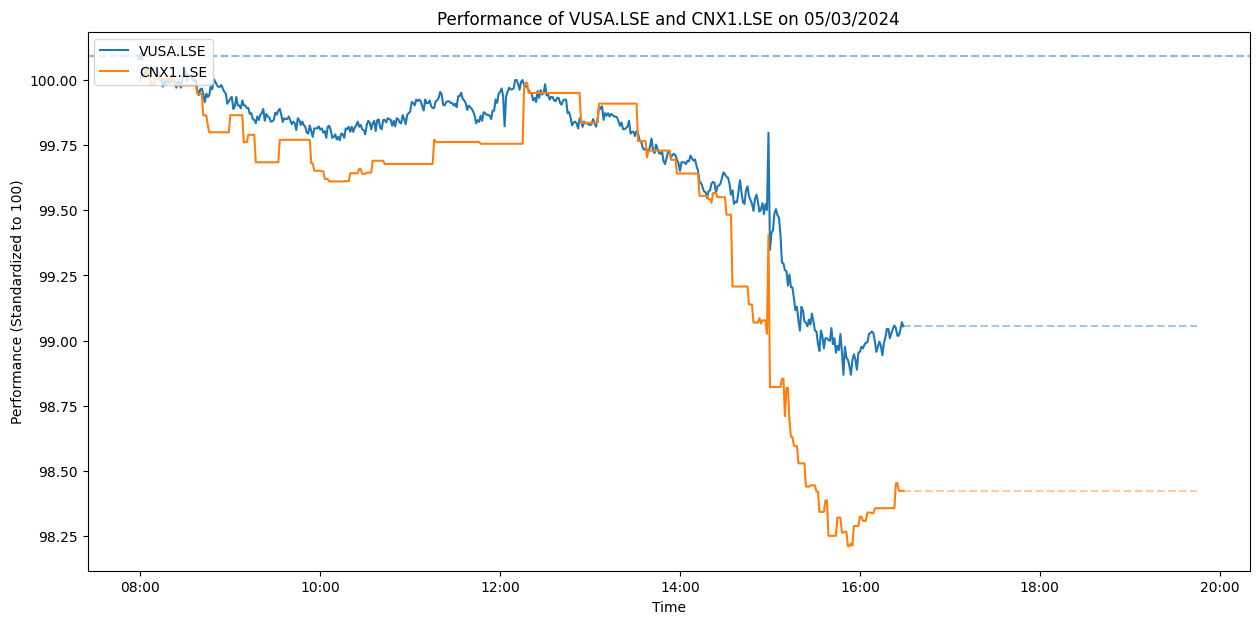

In [7]:
from pytz import timezone

data = pd.concat([
    strategy_utils.get_today_data(
        ticker=ticker, 
        columns="Close", 
    ).to_frame(name=ticker)
    for ticker in YAHOO_TRADABLES
], axis=1)
data.columns = TRADABLES
data = data.ffill()
ret = 100 * (data.pct_change(fill_method=None).fillna(0.0) + 1).cumprod()
ret.index = ret.index.tz_convert("Europe/London")

ret2 = pd.DataFrame(ret.iloc[-1].to_dict(), index=pd.date_range(start=ret.index[-1], end=dt.datetime.now(tz=timezone("Europe/London")), freq="1min"))

last_close = pd.concat([
    strategy_utils.get_intraday_data(
        ticker=ticker, 
        columns="Close",
        start=calc_date-dt.timedelta(days=7), 
        end=calc_date,
    ).to_frame(name=ticker)
    for ticker in TRADABLES
], axis=1)
last_close = last_close.loc[(last_close.index.date != calc_date)].iloc[-1]


from matplotlib import pyplot as plt
from matplotlib import dates

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_map = {asset: colors[i] for i, asset in enumerate(TRADABLES)}

fig, ax = plt.subplots(figsize=(15, 7))
for asset in TRADABLES:
    ax.plot(ret[asset], color=color_map[asset], label=asset)
    last = 100 * last_close[asset] / data[asset].dropna().iloc[0]
    ax.scatter([ret.index[0]], [last], color=color_map[asset], marker="*")
    ax.axhline(y=last, color=color_map[asset], linestyle="--", alpha=0.5)
    ax.plot(ret2[asset], alpha=0.4, linestyle="--", color=color_map[asset])
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
plt.xlabel("Time")
plt.ylabel("Performance (Standardized to 100)")
plt.title(f"Performance of {', '.join(TRADABLES[:-1]) + f' and {TRADABLES[-1]}'} on {calc_date:%d/%m/%Y}")
plt.legend(loc="upper left")
plt.show()


In [8]:
# Fetch active strategies
active_strategies = get_active_strategies(strategy_map=STRATEGY_UNIVERSE_MAP, date=calc_date)
active_strategies

{}
remove api from here
{}
remove api from here


2024-03-05 19:45:24.085 | INFO     | __main__:get_active_strategies:42 - Active: 'pay_day_strategy' -> VUSA.LSE,CNX1.LSE


{}
remove api from here


2024-03-05 19:45:25.680 | INFO     | __main__:get_active_strategies:69 - Active: 'turn_around_tuesday_strategy' -> 'VUSA.LSE'


{}
remove api from here


2024-03-05 19:45:26.934 | INFO     | __main__:get_active_strategies:69 - Active: 'turn_around_tuesday_strategy' -> 'CNX1.LSE'


{'pay_day_strategy': ['VUSA.LSE', 'CNX1.LSE'],
 'turn_around_tuesday_strategy': ['VUSA.LSE', 'CNX1.LSE']}

In [9]:
X_raw = pd.concat([pd.DataFrame(0, index=[calc_date], columns=pd.MultiIndex.from_product([[key], values])) for key, values in STRATEGY_UNIVERSE_MAP.items()], axis=1)
for strat_name, strat_assets in active_strategies.items():
    for strat_asset in strat_assets:
        X_raw.loc[calc_date, (X_raw.columns.get_level_values(0) == strat_name) & (X_raw.columns.get_level_values(1) == strat_asset)] = 1
X_raw

super_bowl          short_term_reversal           \
             VUSA.LSE CNX1.LSE            VUSA.LSE CNX1.LSE   
2024-03-05          0        0                   0        0   

           buy_when_yields_are_low          pay_day_strategy           \
                          VUSA.LSE CNX1.LSE         VUSA.LSE CNX1.LSE   
2024-03-05                       0        0                1        1   

           santa_claus_strategy          september_bear           \
                       VUSA.LSE CNX1.LSE       VUSA.LSE CNX1.LSE   
2024-03-05                    0        0              0        0   

           tax_day_strategy          turn_around_tuesday_strategy           
                   VUSA.LSE CNX1.LSE                     VUSA.LSE CNX1.LSE  
2024-03-05                0        0                            1        1

In [12]:
alloc = X_raw.T.groupby(level=1).sum()
alloc = alloc.div(alloc.sum())
alloc

,2024-03-05
CNX1.LSE,0.5
VUSA.LSE,0.5


In [13]:
CASH = 5165.68

In [14]:
CASH * alloc

,2024-03-05
CNX1.LSE,2582.84
VUSA.LSE,2582.84
